In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
import multiprocessing as mp
from time import sleep
import workers # custom script
%matplotlib inline

In [2]:
image = cv2.imread('Pirate.tif', 0)

In [3]:
def create_noisy_image(image, noise_std):
    np.random.seed(2021)
    noisy_image = image + np.random.normal(scale=noise_std, size=image.shape)
    return np.clip(noisy_image, 0, 255)

In [4]:
def plot_image(image, legend):
    fig, ax = plt.subplots(1)
    ax.imshow(image, interpolation='nearest', cmap = 'gray')
    ax.text(20, 30, legend, bbox={'facecolor': 'white', 'pad': 10}, size = 16)
    fig.set_figheight(10)
    fig.set_figwidth(10)

In [5]:
def tv_denoise_core(noisy_image, delta, eps, L, mu, maxiter):
        pobj = 0
        dobj = 0
        res_l = []
        m, n = noisy_image.shape
        mn = m * n
        noisy_image = noisy_image.flatten()
        x = noisy_image.copy()
        wk = np.zeros(mn)
        uij = np.zeros(2)
        print(f'Maxiter:{maxiter}')
        for k in range(maxiter):
            print(f'{k} iteration')
            df = np.zeros(mn)
            pobj = 0
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.linalg.norm(uij)
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij = uij / c2
                    
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_image) - delta * np.linalg.norm(df)
            res = pobj - dobj
            print(res)
            res_l.append(res)
            if res < eps:
                break
        #step 2
            y_k = (L * (x - noisy_image) - df)/ (max(L, np.linalg.norm(L * (x - noisy_image) - df) / delta)) + noisy_image
        #step3
            wk += ((k + 1) / 2) * df
            zk = -wk / max(L, np.linalg.norm(wk) / delta) + noisy_image
        #step4
            x = 2 /(k + 3) *zk + (k + 1)/(k + 3) * y_k
        return x, res_l

In [6]:
def tv_denoise_core_parallel(noisy_image, delta, eps, L, mu, maxiter): 
        pobj = 0
        dobj = 0
        res_l = []
        m = noisy_image.shape[0]
        n = noisy_image.shape[1]
        mn = m * n
        noisy_image = noisy_image.flatten()
        wk = np.zeros(mn)
        x = noisy_image.copy()
        uij = np.zeros(2)
        print(f'Maxiter:{maxiter}')
        for k in range(maxiter):
            print(f'{k} iteration')
            pobj = 0
            df = np.zeros(mn)
            # step1
            for j in range(n - 1):
                for i in range(m - 1):
                    i1 = (i + 1) + j * m
                    i2 = i + (j + 1) * m
                    i3 = i + j * m
                    uij[0] = x[i1] - x[i3]
                    uij[1] = x[i2] - x[i3]
                    
                    c1 = np.linalg.norm(uij)
                    pobj += c1
                    
                    c2 = max(mu, c1)
                    uij = uij / c2
                                        
                    df[i1] += uij[0]
                    df[i3] -= uij[0]
                    df[i2] += uij[1]
                    df[i3] -= uij[1]
                    
            dobj = df.dot(noisy_image) - delta * np.linalg.norm(df)
            res = pobj - dobj
            print(res)
            res_l.append(res)
            if res < eps:
                break
            with mp.Pool(2) as pool: # step 2 step 3 in parallel
                results = [pool.apply_async(workers.y_count, (L, x, noisy_image, df, delta)),
                           pool.apply_async(workers.z_count, (wk, k, df, L, delta, noisy_image))]
                y_k = results[0].get()
                wk, zk = results[1].get()
            #step4
            x = ((2 /(k + 3)) * zk) + (((k + 1)/(k + 3)) * y_k)
        return x, res_l

In [7]:
def TVdenoise(noisy_image, delta, sigma, tau, parallel, eps_rel = 1e-3):
    alpha = np.sum(noisy_image.flatten()) / len(noisy_image)
    X = alpha * np.ones(noisy_image.shape)
    mdelta = np.linalg.norm(X - noisy_image, 'fro')
    if mdelta < delta:
        return noisy_image # noisy image is a solution (noise is low)
    elif mdelta < 1.1 * delta:
        print('Convergence problems may arise')
    R = noisy_image.max()
    mn = noisy_image.shape[0] * noisy_image.shape[1]
    epsilon = R * mn * eps_rel
    mu = epsilon / mn
    Lmu = 8 / mu
    N = ((4 * np.sqrt(2) * tau * sigma) / (eps_rel * R)).astype(int) # maxiter 
    if parallel:
        X, res = tv_denoise_core_parallel(noisy_image, delta, epsilon, Lmu, mu, N) 
    else:
        X, res = tv_denoise_core(noisy_image, delta, epsilon, Lmu, mu, N)
    return X, res

In [8]:
def TVdenoise_demonstration(image_path, noise_std, tau, parallel = True):
    image = cv2.imread(image_path, 0)
    noisy_image = create_noisy_image(image, noise_std)
    height = noisy_image.shape[0]
    width = noisy_image.shape[1]
    delta = tau * np.sqrt(height * width) * noise_std
    denoised_image, res = TVdenoise(noisy_image, delta, noise_std, tau, parallel)
    denoised_image = denoised_image.reshape((height, width)) 
    plot_image(image, 'Clear image')
    plot_image(noisy_image, 'Noisy image')
    plot_image(denoised_image, 'Denoised image')
    return denoised_image, res

# Parallel

Maxiter:471
0 iteration
11129905.782473002
1 iteration
11099901.62418311
2 iteration
11060736.80489142
3 iteration
11012454.417032938
4 iteration
10954627.419192763
5 iteration
10886994.62998658
6 iteration
10809427.998385368
7 iteration
10721667.290081235
8 iteration
10623742.926793307
9 iteration
10515749.475017546
10 iteration
10397372.452103699
11 iteration
10269609.76443172
12 iteration
10132047.715875968
13 iteration
9984732.188159423
14 iteration
9827934.495408015
15 iteration
9662099.51405652
16 iteration
9487641.87316468
17 iteration
9304579.224490901
18 iteration
9112672.742802227
19 iteration
8913326.849719435
20 iteration
8706590.969925698
21 iteration
8493172.3070275
22 iteration
8273316.87627252
23 iteration
8048895.851650599
24 iteration
7819008.427982004
25 iteration
7585934.177371608
26 iteration
7350845.793259839
27 iteration
7115083.114079613
28 iteration
6878862.718763973
29 iteration
6645379.17342292
30 iteration
6415748.460964175
31 iteration
6191612.090969788
32 

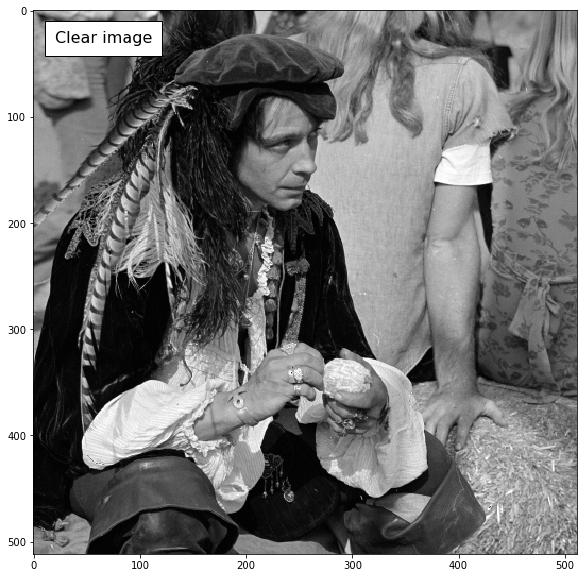

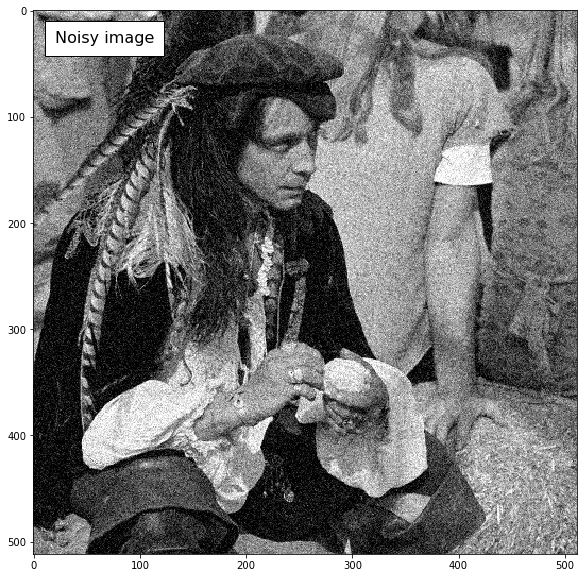

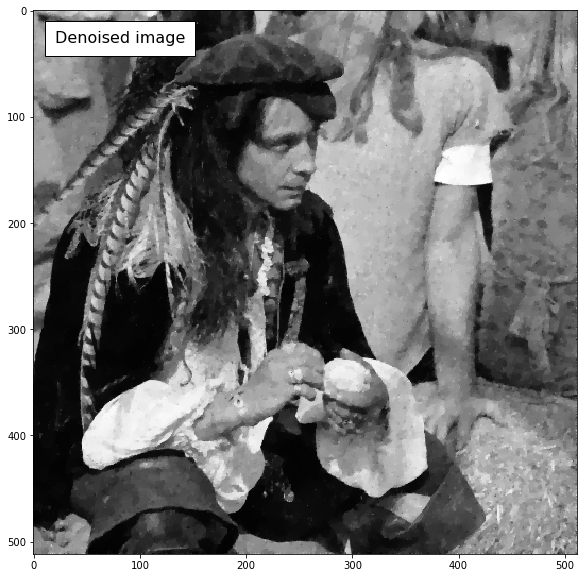

In [9]:
%%time
denoised_img, resid = TVdenoise_demonstration('Pirate.tif', 25, 0.85, True)

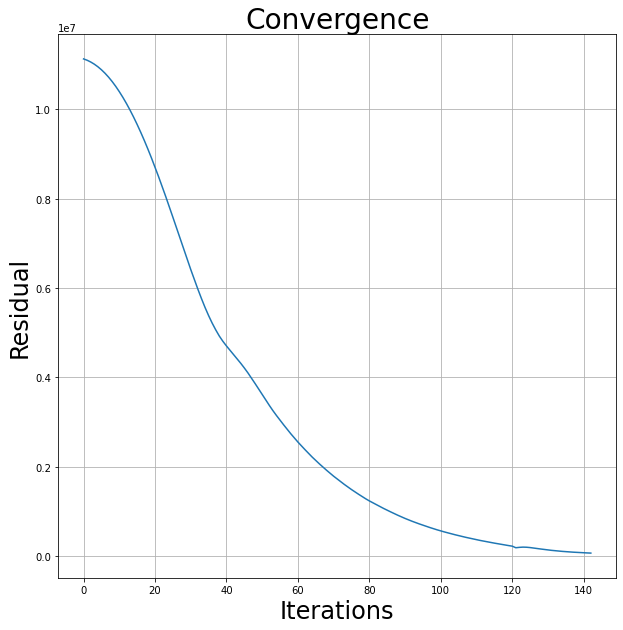

In [10]:
plt.figure(figsize=(10, 10))
plt.plot(resid)
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);

# Not parallel

Maxiter:471
0 iteration
11129905.782473002
1 iteration
11099901.62418311
2 iteration
11060736.80489142
3 iteration
11012454.417032938
4 iteration
10954627.419192763
5 iteration
10886994.62998658
6 iteration
10809427.998385368
7 iteration
10721667.290081235
8 iteration
10623742.926793307
9 iteration
10515749.475017546
10 iteration
10397372.452103699
11 iteration
10269609.76443172
12 iteration
10132047.715875968
13 iteration
9984732.188159423
14 iteration
9827934.495408015
15 iteration
9662099.51405652
16 iteration
9487641.87316468
17 iteration
9304579.224490901
18 iteration
9112672.742802227
19 iteration
8913326.849719435
20 iteration
8706590.969925698
21 iteration
8493172.3070275
22 iteration
8273316.87627252
23 iteration
8048895.851650599
24 iteration
7819008.427982004
25 iteration
7585934.177371608
26 iteration
7350845.793259839
27 iteration
7115083.114079613
28 iteration
6878862.718763973
29 iteration
6645379.17342292
30 iteration
6415748.460964175
31 iteration
6191612.090969788
32 

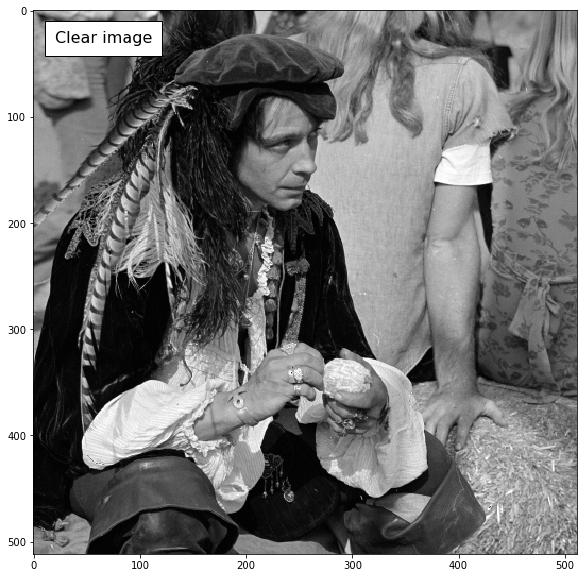

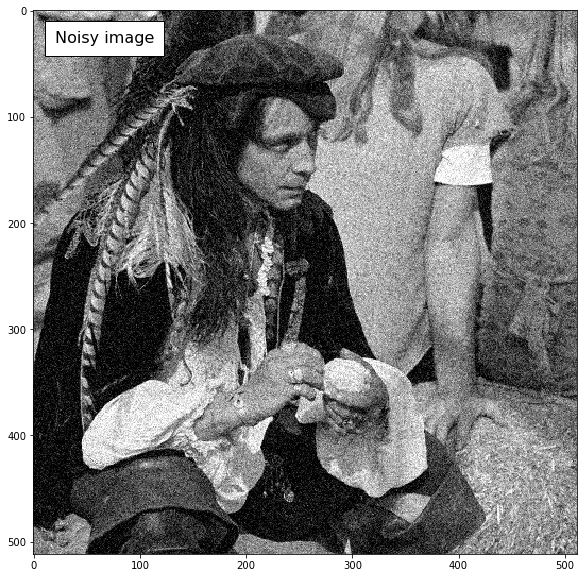

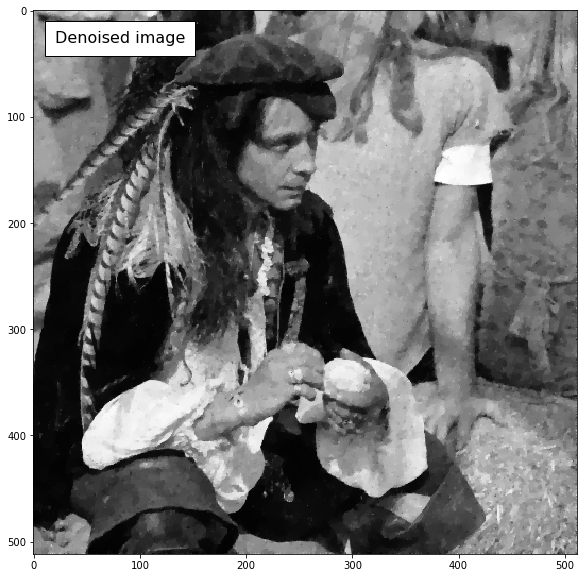

In [11]:
%%time
denoised_img, resid = TVdenoise_demonstration('Pirate.tif', 25, 0.85, False)

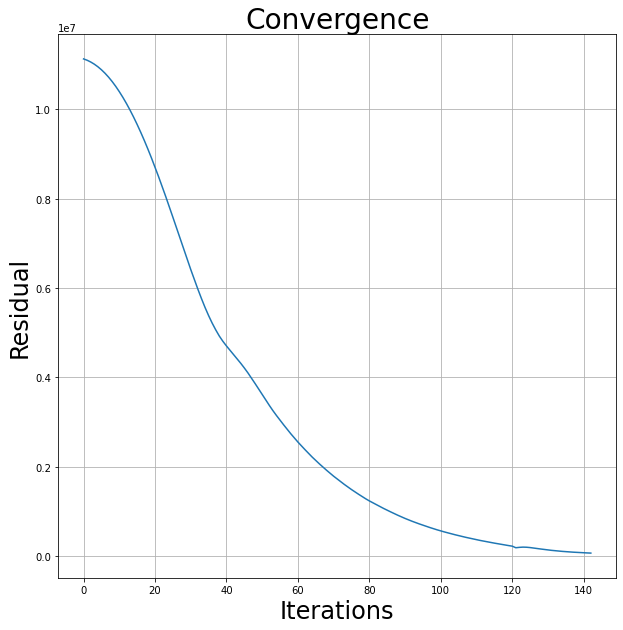

In [12]:
plt.figure(figsize=(10, 10))
plt.plot(resid)
plt.grid(True)
plt.xlabel('Iterations', size=24)
plt.ylabel('Residual', size=24)
plt.title('Convergence', size=28);